In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from sklearn.metrics import cohen_kappa_score, confusion_matrix, accuracy_score
import numpy as np
import os
from PIL import Image
import random

# Set seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

# Configuration
BATCH_SIZE = 32
LR = 1e-4
NUM_CLASSES = 3
NUM_EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Custom Dataset (folder-based)
class CTScanDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        class_mapping = {
            'Lung Cancer': 0,
            'Normal': 1,
            'unsplash-images-collection': 2
        }
        
        for class_name, label in class_mapping.items():
            class_folder = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_folder):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_folder, filename))
                    self.labels.append(label)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load dataset
dataset_path = '/kaggle/input/project/ctscan-dataset-lung'  # <- change this
full_dataset = CTScanDataset(root_dir=dataset_path, transform=transform)

# Split dataset
total_size = len(full_dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Oversampling
targets = [label for _, label in train_dataset]
class_sample_count = np.array([targets.count(t) for t in np.unique(targets)])
weights = 1. / class_sample_count
samples_weights = np.array([weights[t] for t in targets])
sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load EfficientNetB3
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(DEVICE)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training and Evaluation Functions
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    preds = []
    labels = []
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds.extend(torch.argmax(outputs, 1).cpu().numpy())
        labels.extend(targets.cpu().numpy())
    
    acc = accuracy_score(labels, preds)
    kappa = cohen_kappa_score(labels, preds)
    return running_loss / len(loader), acc, kappa

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0
    preds = []
    labels = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            
            preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    
    acc = accuracy_score(labels, preds)
    kappa = cohen_kappa_score(labels, preds)
    return running_loss / len(loader), acc, kappa

# Train
best_val_acc = 0
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc, train_kappa = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_kappa = evaluate(model, val_loader, criterion)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train Kappa: {train_kappa:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | Val   Kappa: {val_kappa:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_ctscan_model.pth')

# Test
model.load_state_dict(torch.load('best_ctscan_model.pth'))
test_loss, test_acc, test_kappa = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | Test Kappa: {test_kappa:.4f}")

# Confusion Matrix
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 195MB/s]


Epoch [1/30]
Train Loss: 0.5331 | Train Acc: 0.8689 | Train Kappa: 0.8034
Val   Loss: 0.1697 | Val   Acc: 0.9584 | Val   Kappa: 0.9353
Epoch [2/30]
Train Loss: 0.0967 | Train Acc: 0.9796 | Train Kappa: 0.9695
Val   Loss: 0.0648 | Val   Acc: 0.9804 | Val   Kappa: 0.9698
Epoch [3/30]
Train Loss: 0.0530 | Train Acc: 0.9902 | Train Kappa: 0.9853
Val   Loss: 0.0357 | Val   Acc: 0.9927 | Val   Kappa: 0.9886
Epoch [4/30]
Train Loss: 0.0405 | Train Acc: 0.9902 | Train Kappa: 0.9853
Val   Loss: 0.0273 | Val   Acc: 0.9951 | Val   Kappa: 0.9924
Epoch [5/30]
Train Loss: 0.0181 | Train Acc: 0.9951 | Train Kappa: 0.9927
Val   Loss: 0.0253 | Val   Acc: 0.9927 | Val   Kappa: 0.9886
Epoch [6/30]
Train Loss: 0.0120 | Train Acc: 1.0000 | Train Kappa: 1.0000
Val   Loss: 0.0247 | Val   Acc: 0.9927 | Val   Kappa: 0.9886
Epoch [7/30]
Train Loss: 0.0069 | Train Acc: 0.9992 | Train Kappa: 0.9988
Val   Loss: 0.0283 | Val   Acc: 0.9951 | Val   Kappa: 0.9924
Epoch [8/30]
Train Loss: 0.0038 | Train Acc: 1.0000 | T

/tmp/ipykernel_31/3113302239.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_ctscan_model.pth'))


Test Loss: 0.0177 | Test Acc: 0.9927 | Test Kappa: 0.9887
Confusion Matrix:
[[153   2   0]
 [  1  86   0]
 [  0   0 169]]


In [2]:
from sklearn.metrics import classification_report, f1_score

# F1 Score (macro averaged)
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"F1 Score (macro): {f1:.4f}")

# Full Classification Report
report = classification_report(all_labels, all_preds, target_names=['Cancer', 'Normal', 'Unknown'])
print("Classification Report:")
print(report)


F1 Score (macro): 0.9910
Classification Report:
              precision    recall  f1-score   support

      Cancer       0.99      0.99      0.99       155
      Normal       0.98      0.99      0.98        87
     Unknown       1.00      1.00      1.00       169

    accuracy                           0.99       411
   macro avg       0.99      0.99      0.99       411
weighted avg       0.99      0.99      0.99       411



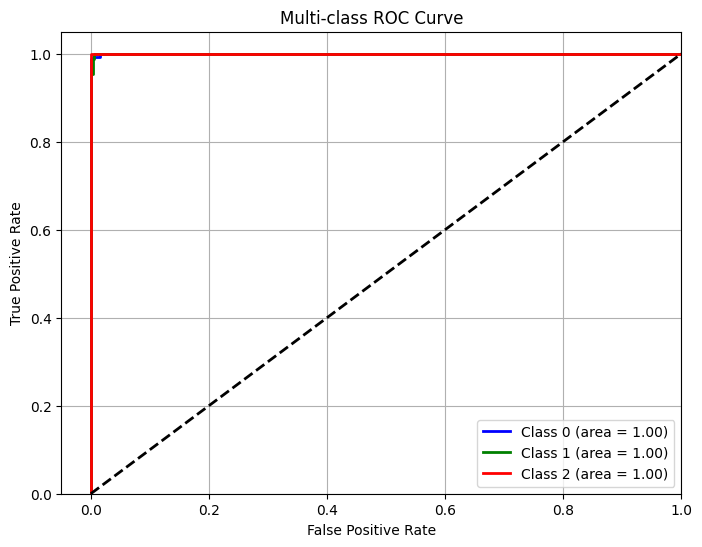

In [3]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities
model.eval()
probs = []
targets_list = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        probs.append(outputs.softmax(dim=1).cpu().numpy())
        targets_list.append(targets.numpy())

probs = np.vstack(probs)
targets_list = np.hstack(targets_list)

# Binarize the labels for multi-class ROC
targets_bin = label_binarize(targets_list, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(targets_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8,6))
colors = ['blue', 'green', 'red']
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
